In [1]:
#Mounting drive to colab
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/Datasets/train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Datasets/train


In [2]:
# Importing libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#Images are present in the location - '/images/'
#Annotations are present in the location - '/annot/'
path = "images"
annot = "annot"

1.jpg


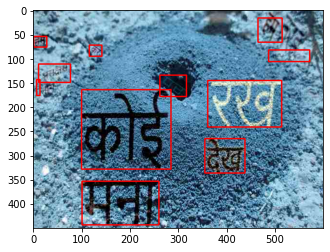

In [4]:
#Example of the dataset
i = "1.txt"
filename = i.split(".")[0]+".jpg"
print(filename)
img = cv2.imread(os.path.join(path,filename))
f = open(os.path.join(annot,i), "r")
plt.imshow(img)
for x in f:
    tmp = x.split(' ')[:8]
    x1 = int(float(min(tmp[:4])))
    y1 = int(float(min(tmp[4:])))
    x2 = int(float(max(tmp[:4])))
    y2 = int(float(max(tmp[4:])))
    cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
plt.imshow(img)

In [5]:
#Example of selective search algorithm
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

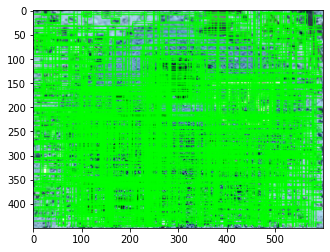

In [6]:
im = cv2.imread(os.path.join(path,"1.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

In [7]:
train_images=[]
train_labels=[]

In [8]:
# Function to get the amount of overlap between 2 rect. boxes
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [9]:
# Iterating through data
# Applying 'Selective Search' algorithm to each image and generate 'Region' proposals
# Preparing datapoints to feed into the classifier network
err = 0
cnt = 0
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
for e,i in enumerate(os.listdir(annot)):
    if(cnt%25==0):
      print(cnt+1,end=' ')
    if((cnt+1)%526==0):
      print()
      print('Done!')
      print('No. of errors thrown : '+str(err))
      break
    cnt += 1
    try:
        if i.endswith(".txt"):
            filename = i.split(".")[0]+".jpg"
            image = cv2.imread(os.path.join(path,filename))
            f = open(os.path.join(annot,i), "r")
            gtvalues=[]
            for x in f:
                tmp = x.split(' ')[:8]
                x1 = int(float(min(tmp[:4])))
                y1 = int(float(min(tmp[4:])))
                x2 = int(float(max(tmp[:4])))
                y2 = int(float(max(tmp[4:])))
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            for e,result in enumerate(ssresults):
                if e < 800:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 15:
                            if iou >= 0.7:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        if falsecounter < 15:
                            if iou <= 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                    if counter>=15 and falsecounter>=15:
                        break
    except Exception as e:
        err += 1
        continue

1 26 51 76 101 126 151 176 201 226 251 276 301 326 351 376 401 426 451 476 501 526 
Done!
No. of errors thrown : 381


In [10]:
# Images to numpy array
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [11]:
X_new.shape

(2992, 224, 224, 3)

In [20]:
# Importing libraries for modeling
from keras import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.losses import categorical_crossentropy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [21]:
# Using VGG-19 for feature extraction
# VGG-19 performed better than Inception models on this dataset
base_model = VGG19(weights='imagenet', include_top=True)

In [59]:
X= base_model.layers[-2].output
predictions = Dense(2, activation="softmax")(X)
model_final = Model(input = base_model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
for layer in model.layers[:12]:
   layer.trainable = False
for layer in model.layers[12:]:
   layer.trainable = True

In [61]:
model.compile(loss = categorical_crossentropy, optimizer = 'adam', metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [62]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)
(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

((2692, 224, 224, 3), (300, 224, 224, 3), (2692, 2), (300, 2))

In [63]:
# Image augumentation
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [64]:
# Transfer Learning on VGG-19 model
model.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 3, validation_data= testdata, validation_steps=2)

Epoch 1/3
10/10 [==============================] - 7s 677ms/step - loss: 0.5544 - accuracy: 0.8870 - val_loss: 0.4652 - val_accuracy: 0.8750
Epoch 2/3
10/10 [==============================] - 4s 367ms/step - loss: 0.4118 - accuracy: 0.8781 - val_loss: 0.4769 - val_accuracy: 0.8125
Epoch 3/3
10/10 [==============================] - 4s 383ms/step - loss: 0.4727 - accuracy: 0.8469 - val_loss: 0.3948 - val_accuracy: 0.8594


Not Text


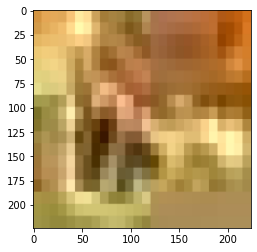

In [65]:
# Classifier result
im = X_test[1]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model.predict(img)
if out[0][0] > out[0][1]:
    print("Text")
else:
    print("Not Text")

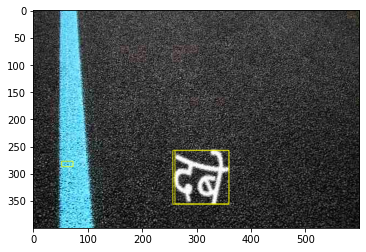

In [85]:
# Again 'Selective Search' is used for region proposals in test image
# Each proposed image is classified by the VGG-19 model
# Yellow-bounding box is the detected text
i = 'test_01.jpg'
img = cv2.imread(i)
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()
imout = img.copy()
res = []
for e,result in enumerate(ssresults):
    if e < 40:
        x,y,w,h = result
        timage = imout[y:y+h,x:x+w]
        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        out = model.predict(img)
        res.append(out[0][0])
        if out[0][0] >= 0.26:
            cv2.rectangle(imout, (x, y), (x+w, y+h), (255, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imout)